In [19]:
from __future__ import division

import math as math
import numpy as np
import scipy as scp
import pylab as pyl
from matplotlib import cm
import matplotlib.pyplot as plt
import scipy.io as sio
from matplotlib.pyplot import imshow as imageplot
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.image as mpimg
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
%load_ext autoreload
%autoreload 2




The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
def enleve3compo(image):
    
    test = np.zeros((image.shape[0],image.shape[1]))

    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            test[i,j] =  image[i,j,0] 
    return test

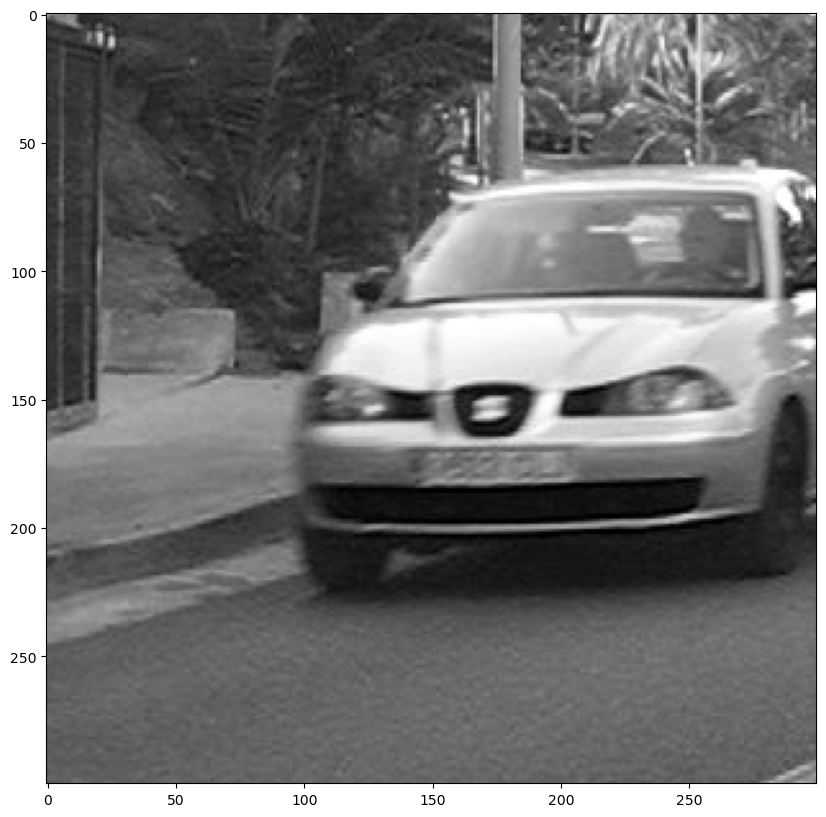

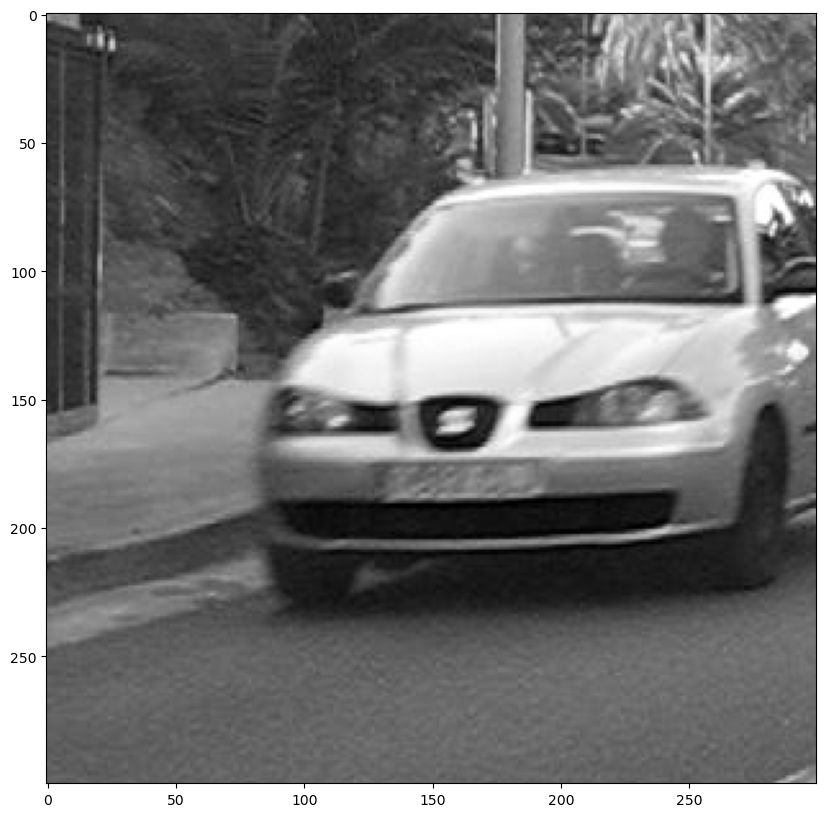

In [21]:
car1 = mpimg.imread("car1_bw.jpg")
car2 = mpimg.imread("car2_bw.jpg")

car1 =  enleve3compo(car1)[150:450,:300]
car2 =  enleve3compo(car2)[150:450,:300]



plt.figure(figsize = (10,10))
plt.imshow(car1,cmap='gray')
plt.show()
plt.figure(figsize = (10,10))
plt.imshow(car2,cmap='gray')
plt.show()

# Travaillons d'abord sur des petites images pour faciliter la compréhension du problème

[[1. 1. 1. 1. 1. 1. 1.]
 [1. 0. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1.]
 [1. 0. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1.]
 [1. 0. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1.]]


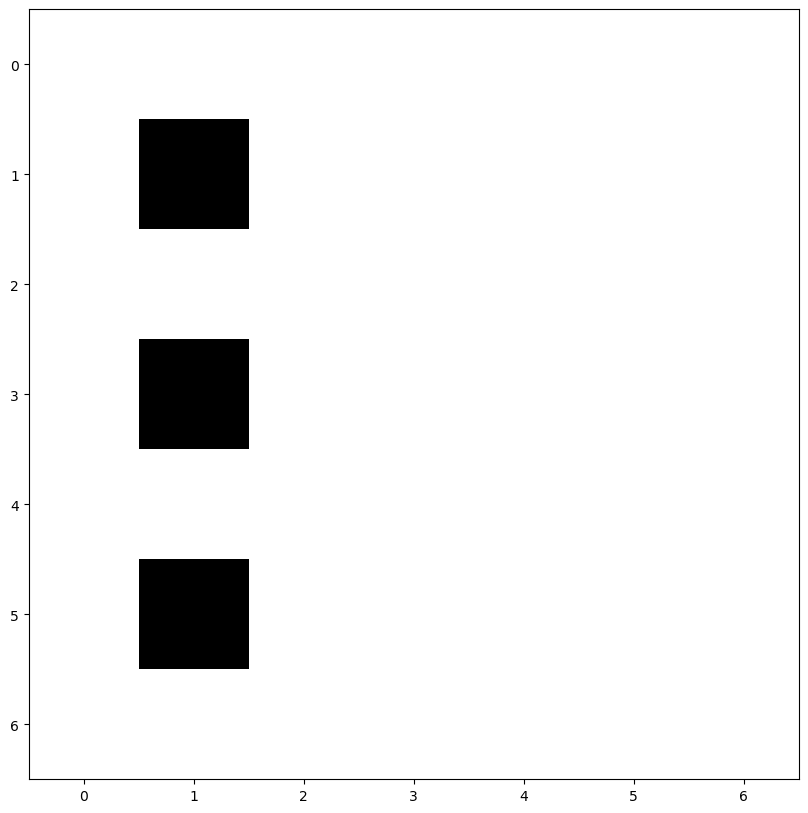

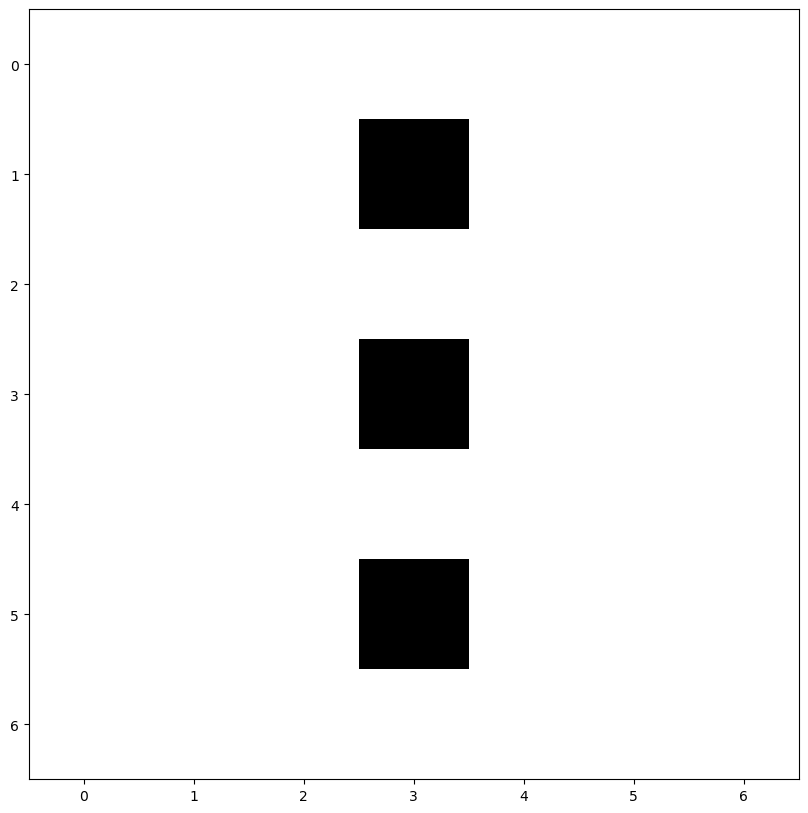

In [22]:
test1 = mpimg.imread("test1.png")
test2 = mpimg.imread("test2.png")
test3 = mpimg.imread("test3.png")

test1 =  enleve3compo(test1)
test2 =  enleve3compo(test2)
test3 =  enleve3compo(test3)

print(test1)

plt.figure(figsize = (10,10))
plt.imshow(test1,cmap='gray')
plt.show()
plt.figure(figsize = (10,10))
plt.imshow(test3,cmap='gray')
plt.show()
# plt.figure(figsize = (10,10))
# plt.imshow(test3,cmap='gray')
# plt.show()

## Implémentation des fonctions :

In [53]:
def grad_x(img, adjoint):
    sx , sy = img.shape[0], img.shape[1]
    diff_x = np.copy(img)
    
    if adjoint==0:
        for x in range(sx):
            if x==sx-1:
                xnext=0
            else:
                xnext=x+1
            for y in range(sy):
                diff_x[x,y] = img[xnext,y]- img[x,y]
    else:
        for x in range(sx):
            if x==0:
                xprev=sx-1
            else:
                xprev=x-1
            for y in range(sy):
                diff_x[x,y] = img[xprev,y]- img[x,y]
    
    return diff_x

def verifie_grad_x(in1,in2):
    tmp1 = sum(sum(grad_x(in1, 0) * in2))
    tmp2 = sum(sum(in1 * grad_x(in2, 1)))
    print(tmp1, ' = ', tmp2,' ?')
    
    return tmp1==tmp2
    
    
def grad_y(img, adjoint):
    sx , sy = img.shape[0], img.shape[1]
    diff_y =  np.copy(img)

    if adjoint==0:
       
        for y in range(sy):
            if y==sy-1:
                ynext=0
            else:
                ynext=y+1
            for x in range(sx):
                diff_y[x,y] = img[x,ynext]- img[x,y]
    else:
        for y in range(sy):
            if y==0:
                yprev=sy-1
            else:
                yprev=y-1
            for x in range(sx):
                diff_y[x,y] = img[x,yprev]- img[x,y]
    
    return diff_y


def verifie_grad_y(in1,in2):
    tmp1 = sum(sum(grad_y(in1, 0) * in2))
    tmp2 = sum(sum(in1 * grad_y(in2, 1)))
    print(tmp1, ' = ', tmp2,' ?')
    
    
def grad(t,adjoint):
    
    m,n = t.shape[0],t.shape[1]

    
    if adjoint == 0:
        
        grad = np.zeros((m, n, 2))
        
        x0 = grad_x(t,0)
        y0 = grad_y(t,0)
        
        for i in range(m):
            for j in range(n):

                grad[i,j] = [x0[i,j] , y0[i,j] ] 
       
                
    
    else:
        grad = np.zeros((m, n))
        x1 = grad_x(t[:,:,0],1)
        y1 = grad_y(t[:,:,1],1)
        for i in range(m):
            for j in range(n):
                
                grad[i,j] = x1[i,j] + y1[i,j]
                
    return grad
    
    
    
def H(t,v1,adjoint):
    m,n = v1.shape
    
    
    if adjoint == 0:
        gradv1 = grad(v1,0)
        out = np.zeros((m,n))
        
        for k in range(m):
            for l in range(n):
                
                out[k,l] = np.dot(gradv1[k,l],t[k,l])
    
    else:
        grad_xv1 = grad_x(v1, 0)
        grad_yv1 = grad_y(v1, 0)
        
        out = np.zeros((m,n,2))
        for k in range(m):
            for l in range(n):
                out[k, l, 0] = grad_xv1[k, l] * t[k, l]
                out[k, l, 1] = grad_yv1[k, l] * t[k, l]
                
    return out

    
def phi(img,eps):
    
    return np.sqrt(img+eps)


def phi_p(img,eps):

    return np.sqrt(1/(4*(img+eps)))


    
def E(t, v1, v2, eps, lamb):
    Ht = H(t, v1, 0)
    m,n = v1.shape
    energie = np.zeros((n,m))
    
    gradv1 = grad(v1,0)
    gradt1 = grad(t[:,:,0],0)
    gradt2 = grad(t[:,:,1],0)
    
    for k in range(m):
        for l in range(n):
            
            energie[k,l] = phi( (v1[k,l] + np.dot( gradv1[k,l], t[k,l] ) - v2[k,l] )**2, eps ) +\
                            np.linalg.norm( gradt1[k,l] )**2 + np.linalg.norm( gradt2[k,l])**2
    return np.sum(energie)


def grad_E(t,v1,v2,eps,lamb):
    
    Ht = H(t,v1,0)
    X = 2*phi_p( (Ht + v1 - v2)**2, eps )*(Ht + v1 - v2)
    
    gradt1 = grad(t[:,:,0],0)
    gradt2 = grad(t[:,:,1],0)
    
    
    stargradt1 = grad(gradt1, 1)
    stargradt2 = grad(gradt2, 1)
    HX = H(X,v1,1)
    gradE = np.zeros(t.shape)
    
    for k in range(t.shape[0]):
        for l in range(t.shape[1]):
            gradE[k,l,0] = HX[k,l,0] + 2*lamb*stargradt1[k,l]
            gradE[k,l,1] = HX[k,l,1] + 2*lamb*stargradt2[k,l]
    
    return gradE


    

## On test pour voir si nos fonctions sont bien défini

In [54]:
eps = 0.1
lamb = 1

m,n = np.shape(car1)

t = np.zeros((m, n,2))    # Champ de vecteurs initial


print("E =",E(t,car1,car2,eps,lamb))
print('grad_E =',grad_E(t,car1,car2,eps,lamb))

E = 1867156.6558887712
grad_E = [[[ -6.99933847 -19.99810991]
  [-36.97112758 -11.99063597]
  [ 45.90827508  -6.98604186]
  ...
  [-33.99411917  75.98685462]
  [-95.99942037 -15.99990339]
  [-92.99949545 -63.99965278]]

 [[ 73.98720055  49.99135173]
  [ 25.99922669  20.9993754 ]
  [  0.99996538 -29.99896127]
  ...
  [ 17.96410764  13.97208372]
  [-12.99668494 -12.99668494]
  [-20.74232153  21.73005113]]

 [[ 35.99971875   1.99998438]
  [ 31.99966394  -3.99995799]
  [ 28.99921582 -13.99962143]
  ...
  [  6.99948231 -16.99874274]
  [  0.99688957 -20.93468102]
  [  0.99989671  30.99679802]]

 ...

 [[  3.98755829   4.98444786]
  [ -1.997228     3.99445599]
  [ -6.98604186  -1.99601196]
  ...
  [  4.99888926   5.99866711]
  [  0.99982703   6.99878924]
  [-12.99711207 -57.98711541]]

 [[  0.           0.        ]
  [  7.62770071   0.95346259]
  [  6.96143221   0.99449032]
  ...
  [  7.99795996   1.99948999]
  [ -1.997228    -6.99029799]
  [  4.98444786  40.87247247]]

 [[-72.10426056   0.  

In [55]:
eps = 0.1
lamb = 1

m,n = np.shape(car1)

t = np.zeros((m, n,2))    # Champ de vecteurs initial


print("E =",E(t,car1,car2,eps,lamb))
print('grad_E =',grad_E(t,car1,car2,eps,lamb))

E = 1867156.6558887712
grad_E = [[[ -6.99933847 -19.99810991]
  [-36.97112758 -11.99063597]
  [ 45.90827508  -6.98604186]
  ...
  [-33.99411917  75.98685462]
  [-95.99942037 -15.99990339]
  [-92.99949545 -63.99965278]]

 [[ 73.98720055  49.99135173]
  [ 25.99922669  20.9993754 ]
  [  0.99996538 -29.99896127]
  ...
  [ 17.96410764  13.97208372]
  [-12.99668494 -12.99668494]
  [-20.74232153  21.73005113]]

 [[ 35.99971875   1.99998438]
  [ 31.99966394  -3.99995799]
  [ 28.99921582 -13.99962143]
  ...
  [  6.99948231 -16.99874274]
  [  0.99688957 -20.93468102]
  [  0.99989671  30.99679802]]

 ...

 [[  3.98755829   4.98444786]
  [ -1.997228     3.99445599]
  [ -6.98604186  -1.99601196]
  ...
  [  4.99888926   5.99866711]
  [  0.99982703   6.99878924]
  [-12.99711207 -57.98711541]]

 [[  0.           0.        ]
  [  7.62770071   0.95346259]
  [  6.96143221   0.99449032]
  ...
  [  7.99795996   1.99948999]
  [ -1.997228    -6.99029799]
  [  4.98444786  40.87247247]]

 [[-72.10426056   0.  

In [56]:
eps = 0.1
lamb = 1

m,n = np.shape(test1)

t = np.zeros((m, n,2))    # Champ de vecteurs initial


print("E =",E(t,test1,test3,eps,lamb))
print('grad_E =',grad_E(t,test1,test2,eps,lamb))

E = 19.89064702774494
grad_E = [[[ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]]

 [[ 0.          0.        ]
  [-0.95346259 -0.95346259]
  [ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]]

 [[ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]]

 [[ 0.          0.        ]
  [-0.95346259 -0.95346259]
  [ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]]

 [[ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.   

# Minimisation par algorithm gradient

In [57]:
def gradient_descent(v1, v2, eps, lamb, pas=0.01, num_iterations=100):
    # Initialiser le tenseur t aléatoirement ou avec des zéros
    m,n = v1.shape
    t = np.zeros((m, n,2))
    
    for _ in range(num_iterations):
        # Calculer le gradient de la fonction énergétique
        grad = grad_E(t, v1, v2, eps, lamb)
        
        # Mettre à jour le tenseur t en utilisant la descente de gradient
        t = t - pas * grad
        
        
        # Print énergie actuelle pour la surveillance
        current_energy = E(t, v1, v2, eps, lamb)
        
        print("Actuelle Energie:", current_energy)
    
    return t


In [35]:
eps = 0.1
lamb = 1

sol_approch = gradient_descent(test1,test3, eps, lamb, pas=0.12, num_iterations=100)

Actuelle Energie: 19.612552566443533
Actuelle Energie: 19.426011334299822
Actuelle Energie: 19.440949088182602
Actuelle Energie: 19.32676746123553
Actuelle Energie: 19.35838864142373
Actuelle Energie: 19.262606083855978
Actuelle Energie: 19.299573758618422
Actuelle Energie: 19.211345869150446
Actuelle Energie: 19.249693410015738
Actuelle Energie: 19.165912158628352
Actuelle Energie: 19.204307668841793
Actuelle Energie: 19.12415579433275
Actuelle Energie: 19.16222023417013
Actuelle Energie: 19.085506165549983
Actuelle Energie: 19.123162064355988
Actuelle Energie: 19.049811876537998
Actuelle Energie: 19.08706027988006
Actuelle Energie: 19.01698287900659
Actuelle Energie: 19.053838358757265
Actuelle Energie: 18.986902851033303
Actuelle Energie: 19.023380500210635
Actuelle Energie: 18.95942245127966
Actuelle Energie: 18.995539179843448
Actuelle Energie: 18.934371219219166
Actuelle Energie: 18.97014927908305
Actuelle Energie: 18.911569970778906
Actuelle Energie: 18.94703952454584
Actuelle E

# Testons sur nos images de la voiture

In [58]:
eps = 0.1
lamb = 1



t_approch = gradient_descent(car1,car2, eps, lamb, pas=0.01, num_iterations=100)

Actuelle Energie: 1738082.8518197546
Actuelle Energie: 1613362.2556908678
Actuelle Energie: 1568530.6555728298
Actuelle Energie: 1494407.2663925597
Actuelle Energie: 1469672.928129529
Actuelle Energie: 1420529.0428990512
Actuelle Energie: 1404268.1236304394
Actuelle Energie: 1369346.591015728
Actuelle Energie: 1357067.6310600098
Actuelle Energie: 1330999.9266244501
Actuelle Energie: 1320474.1518121194
Actuelle Energie: 1301595.5744866387
Actuelle Energie: 1291529.6250730238
Actuelle Energie: 1278108.0979810078
Actuelle Energie: 1268122.1690865948
Actuelle Energie: 1258776.2995134562
Actuelle Energie: 1249022.2928956575
Actuelle Energie: 1243072.548412029
Actuelle Energie: 1232616.664516733
Actuelle Energie: 1229397.5173330517
Actuelle Energie: 1219202.7551869946
Actuelle Energie: 1216848.1820430176
Actuelle Energie: 1207953.8932550903
Actuelle Energie: 1206112.1520860617
Actuelle Energie: 1197739.2045339872
Actuelle Energie: 1196784.91037052
Actuelle Energie: 1188861.387507691
Actuelle

In [59]:
t_approch.shape

(300, 300, 2)

# Affichage des vecteurs sur l'image

In [60]:
def plot_optical_flow(flow_vectors):
    m, n, _ = flow_vectors.shape
    # Créer une grille de coordonnées pour les vecteurs
    X, Y = np.meshgrid(np.arange(0, n, 1), np.arange(0, m, 1))
    
    # Extraire les composantes x et y des vecteurs
    U = flow_vectors[:, :, 0]
    V = flow_vectors[:, :, 1]
    
    # Tracer les flèches du flux optique
    plt.figure(figsize=(10, 6))
    plt.quiver(X, Y, U, V)
    plt.gca().invert_yaxis()  # Inverser l'axe y pour correspondre à l'orientation habituelle des images
    plt.xlabel('Column')
    plt.ylabel('Row')
    plt.title('Optical Flow Vecteurs')
    plt.show()


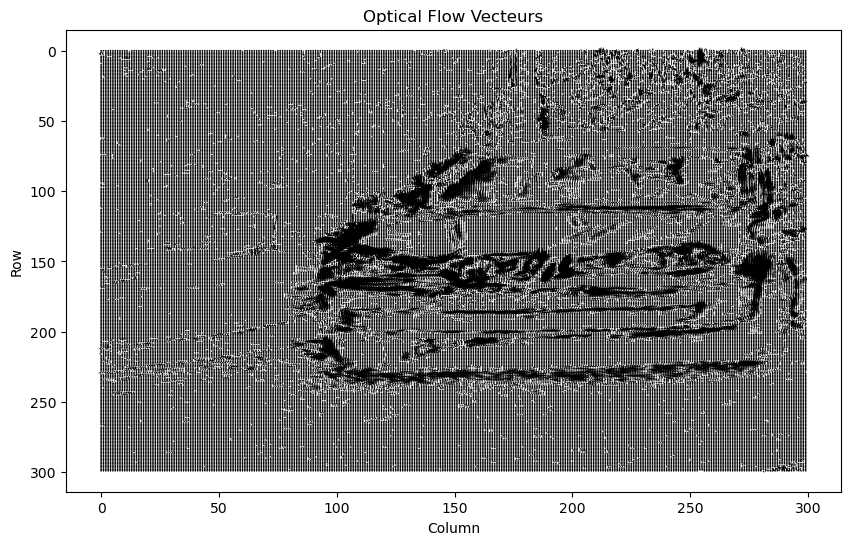

(300, 300, 2)

In [61]:
plot_optical_flow(t_approch)
t_approch.shape

# Superposons le avec l'image initiale

In [62]:
def plot_optical_flow_on_image(image, flow_vectors):
    m, n, _ = flow_vectors.shape
    # Créer une grille de coordonnées pour les vecteurs
    X, Y = np.meshgrid(np.arange(0, n, 1), np.arange(0, m, 1))
    
    # Extraire les composantes x et y des vecteurs
    U = flow_vectors[:, :, 0]
    V = flow_vectors[:, :, 1]
    
    # Inverser l'image verticalement
    image_flipped = np.flipud(image)
    
    # Inverser les composantes verticales des vecteurs
    U_flipped = -np.flipud(U)
    V_flipped = np.flipud(V)
    
    # Afficher l'image d'origine inversée verticalement
    plt.figure(figsize=(10, 6))
    plt.imshow(image_flipped)
    
    # Tracer les flèches du flux optique par-dessus l'image
    plt.quiver(X, Y, U_flipped, V_flipped, color='red')  # Vous pouvez ajuster la couleur selon vos besoins
    plt.gca().invert_yaxis()  # Inverser l'axe y pour correspondre à l'orientation habituelle des images
    plt.xlabel('Column')
    plt.ylabel('Row')
    plt.title("Vecteurs recalage de l'image initale")
    plt.show()



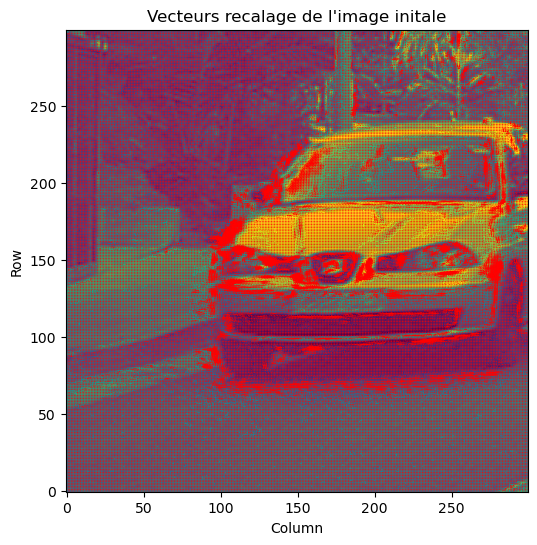

In [63]:
plot_optical_flow_on_image(car1, t_approch)

In [64]:
car1_tilde = np.zeros(car1.shape)

for m in range(car1_tilde.shape[0]):
    for n in range(car1_tilde.shape[1]):
        car1_tilde[m,n] = car1[ int( np.floor( m + t_approch[m,n,0]) )%car1_tilde.shape[0] ,\
                               int(  np.floor( n + t_approch[m,n,1]) )%car1_tilde.shape[0] ]
        


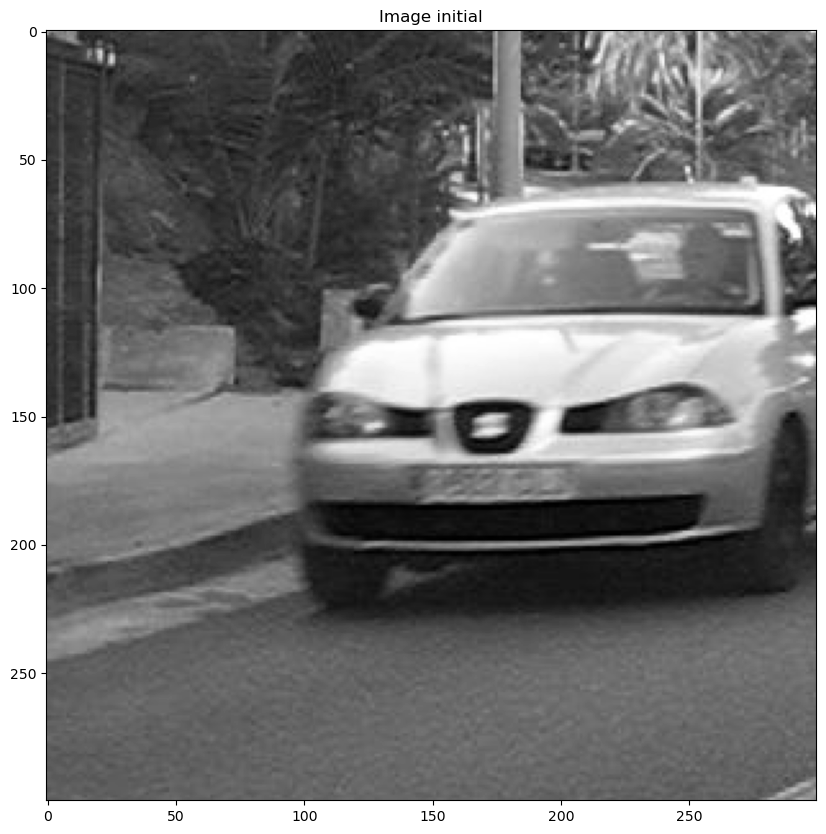

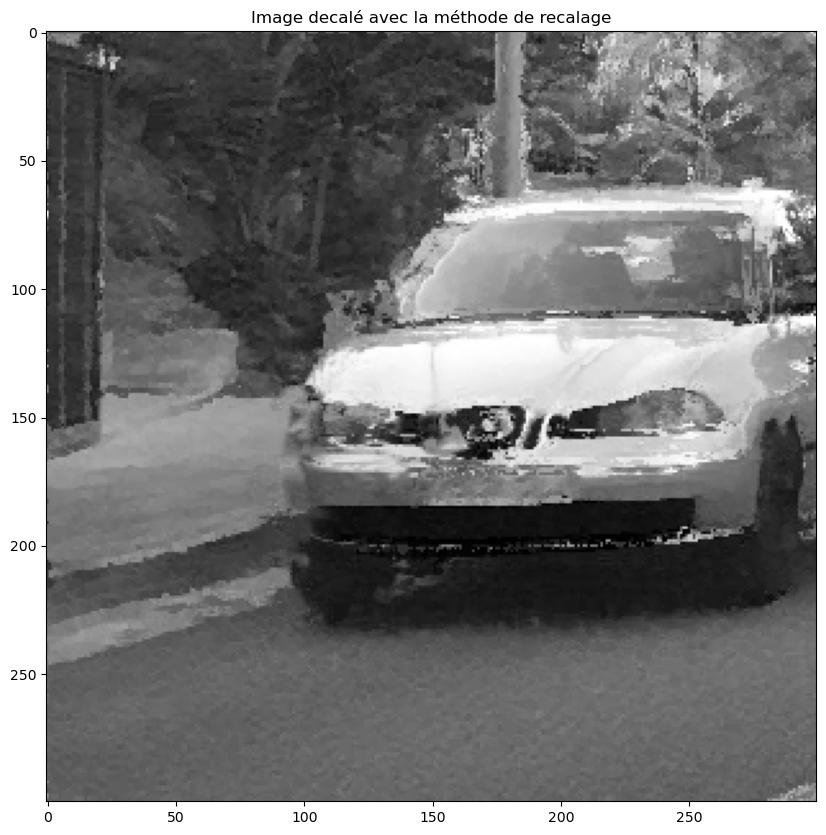

In [65]:

plt.figure(figsize = (10,10))
plt.title("Image initial")
plt.imshow(car1,cmap='gray')
plt.show()

plt.figure(figsize = (10,10))
plt.title("Image decalé avec la méthode de recalage")
plt.imshow(car1_tilde,cmap='gray')
plt.show()

# plt.figure(figsize = (10,10))
# plt.title("Image Final réel")
# plt.imshow(car2,cmap='gray')
# plt.show()

# Testons sur d'autres images

(400, 400)
(400, 400)


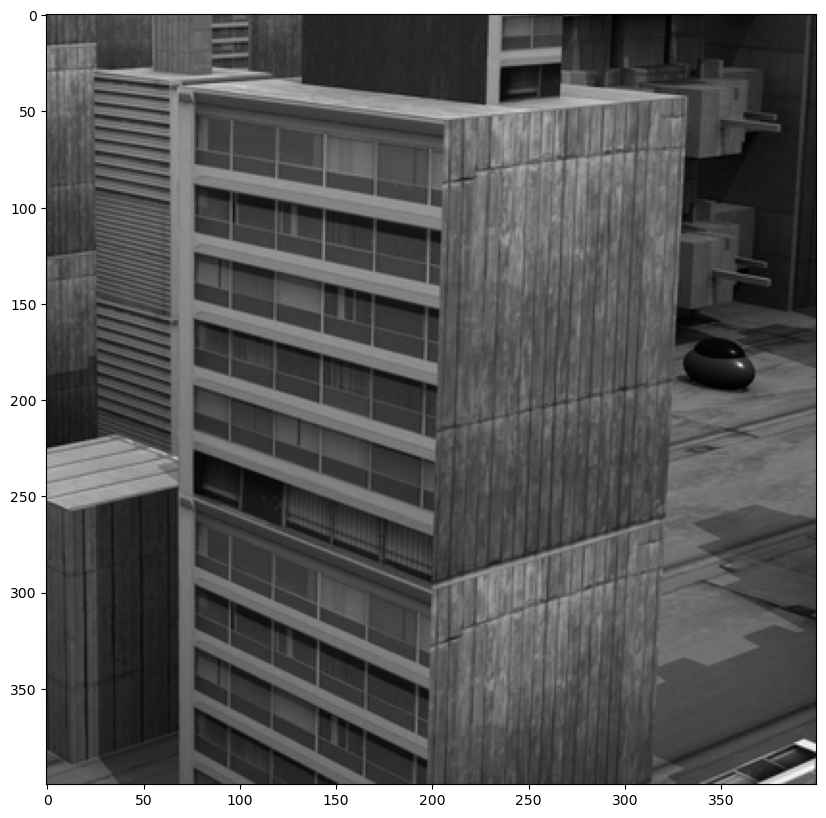

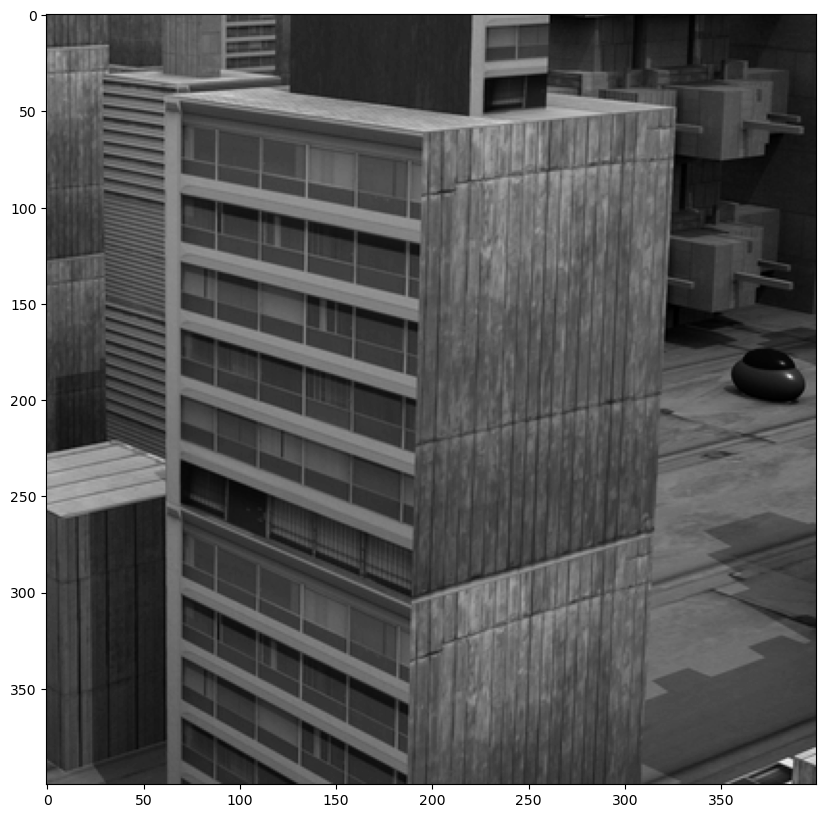

In [66]:
frame11 = mpimg.imread("frame11.png")
frame13 = mpimg.imread("frame13.png")

frame11 = frame11[80:,240:]
frame13 = frame13[80:,240:]

print(frame11.shape)
print(frame13.shape)


plt.figure(figsize = (10,10))
plt.imshow(frame11,cmap='gray')
plt.show()
plt.figure(figsize = (10,10))
plt.imshow(frame13,cmap='gray')
plt.show()

In [67]:
eps = 0.1
lamb = 1

t_approch2 = gradient_descent(frame11,frame13, eps, lamb, pas=0.01, num_iterations=100)

Actuelle Energie: 52584.84071504229
Actuelle Energie: 52584.576294615654
Actuelle Energie: 52584.334865014964
Actuelle Energie: 52584.11338474025
Actuelle Energie: 52583.90927791603
Actuelle Energie: 52583.720356172606
Actuelle Energie: 52583.54475462025
Actuelle Energie: 52583.38087920852
Actuelle Energie: 52583.22736331213
Actuelle Energie: 52583.083031819144
Actuelle Energie: 52582.94687133819
Actuelle Energie: 52582.81800541203
Actuelle Energie: 52582.69567383907
Actuelle Energie: 52582.57921537599
Actuelle Energie: 52582.4680532303
Actuelle Energie: 52582.36168286229
Actuelle Energie: 52582.25966170292
Actuelle Energie: 52582.16160046582
Actuelle Energie: 52582.067155788776
Actuelle Energie: 52581.97602398673
Actuelle Energie: 52581.88793573635
Actuelle Energie: 52581.80265154326
Actuelle Energie: 52581.719957867834
Actuelle Energie: 52581.63966380711
Actuelle Energie: 52581.5615982466
Actuelle Energie: 52581.48560741052
Actuelle Energie: 52581.4115527501
Actuelle Energie: 52581.3

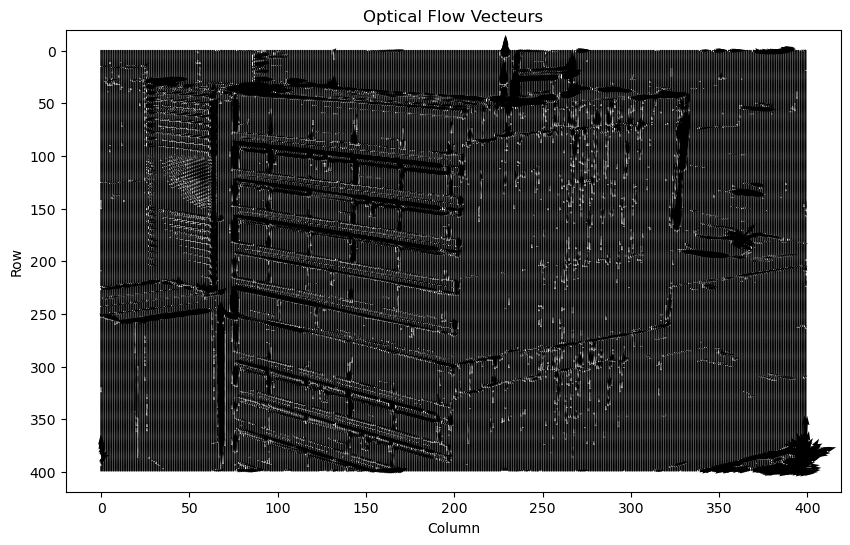

(400, 400, 2)

In [68]:
plot_optical_flow(t_approch2)
t_approch2.shape

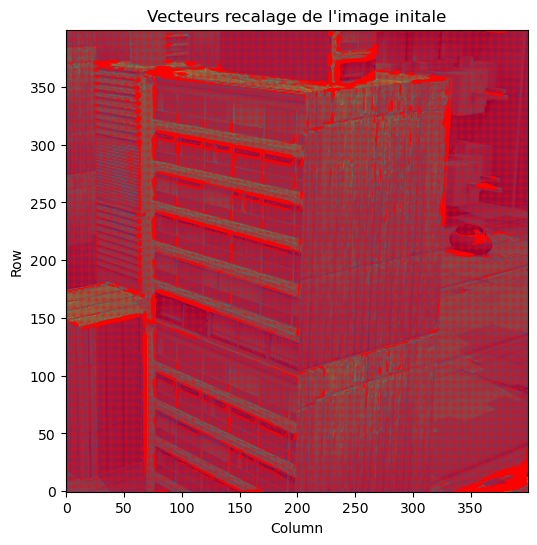

In [69]:
plot_optical_flow_on_image(frame11, t_approch2)